## Experiment 10: Compare CAE and 4-split MICAE decoders
The decoder activations of both CAE and 4-split look quite similar. This suggests that the decoder is in large part responsible for the image quality.

In [12]:
import sys; sys.path.insert(0, '..')
from keras import models
import dataset
import matplotlib.pyplot as plt
import numpy as np
import random
random.seed(1)

In [4]:
batch_size = 32

cae_test_gen = dataset.BatchGenerator(dataset.x_test, 1, batch_size)
micae_test_gen = dataset.BatchGenerator2(dataset.x_test, batch_size)

In [9]:
micae4x4 = models.load_model('../models/micae_4split_4x4FixedLatent_300epochs')
cae16 = models.load_model('../models/cae_16FreeLatent_300epochs')

In [59]:
from keras.utils import plot_model

# plot_model(cae16, expand_nested=True)
plot_model(micae4x4, expand_nested=True)
print(micae4x4.layers)

[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fc01c78f790>, <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fc01c78f520>, <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fc02c19fa00>, <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fc02c19f5e0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc02c19f7c0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc02c17c3a0>, <tensorflow.python.keras.layers.core.Flatten object at 0x7fc02c19d2e0>, <tensorflow.python.keras.layers.core.Dense object at 0x7fc02c182070>, <tensorflow.python.keras.layers.merge.Concatenate object at 0x7fc02c182190>, <tensorflow.python.keras.layers.core.Dense object at 0x7fc02c04ff70>, <tensorflow.python.keras.layers.core.Reshape object at 0x7fc02c04f430>, <tensorflow.python.keras.layers.convolutional.Conv2DTranspose object at 0x7fc01c5dbf10>, <tensorflow.python.keras.layers.convolutional.Conv2DTranspose

In [6]:
def post_process_img(img):
    img -= img.mean()
    img /= img.std() # standardize
    img *= 64  # scale
    img += 128 # shift
    return np.clip(img, 0, 255).astype('uint8')

In [79]:
def plot_activation(model, model_input):
    # 1. Define new multi-out model 
    activation_model = models.Model(inputs=model.input, outputs=[layer.output for layer in model.layers])
    # 2. Predict on activation_model
    activations = activation_model.predict(model_input)
    # 3. Loop through activations and plot
    n_per_row = 16
    for (layer, activation) in zip(model.layers, activations):
        if 'conv2d_transpose' in layer.name:
            n_filters = activation.shape[-1]
            n_cols = n_filters // n_per_row
            size = activation.shape[1]
            grid = np.zeros((size*n_cols, size*n_per_row))
            for col in range(n_cols):
                for row in range(n_per_row):
                    img = activation[0,:,:,col*n_per_row+row]  # select one filter at a time
                    img = post_process_img(img)
                    grid[col*size:(col+1)*size, row*size:(row+1)*size] = img
            scale = 1. / size
            plt.figure(figsize=(scale*grid.shape[1], scale*grid.shape[0]))
            plt.title(layer.name)
            plt.grid(False)
            plt.imshow(grid, aspect='auto', cmap='viridis')

<ipython-input-79-f2993a9773b1>:23: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(grid, aspect='auto', cmap='viridis')


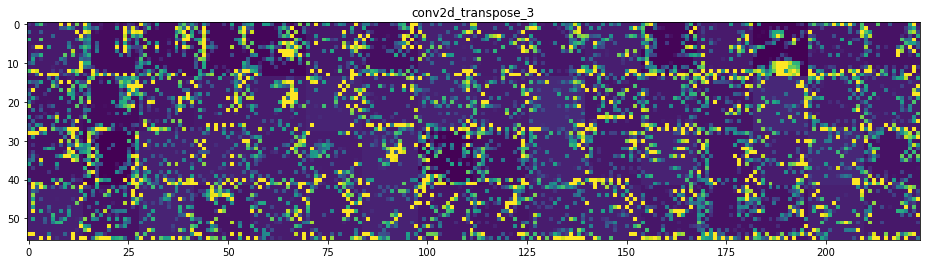

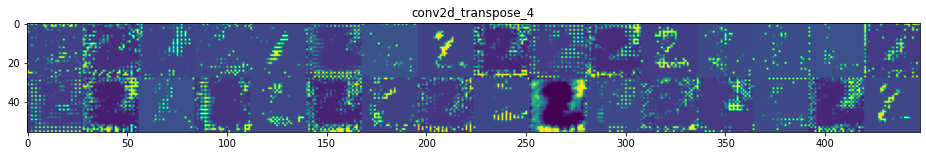

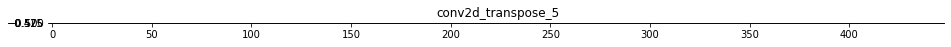

In [83]:
enc_in = dataset.x_test[1].reshape(1,28,28,1)
dec_in = cae16.layers[1].predict(enc_in)
dec = cae16.layers[2]
plot_activation(dec, dec_in)

<ipython-input-79-f2993a9773b1>:23: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(grid, aspect='auto', cmap='viridis')


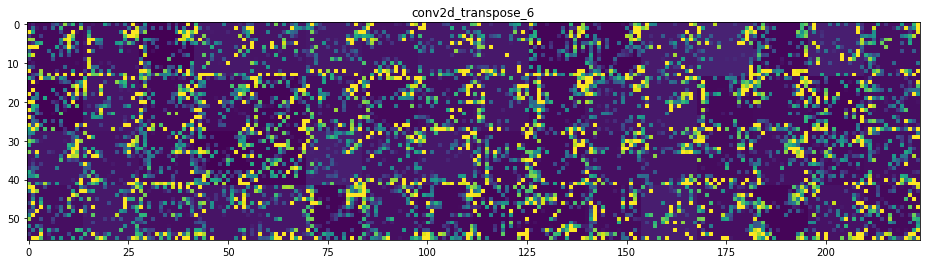

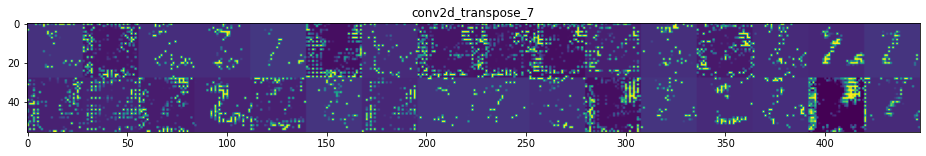

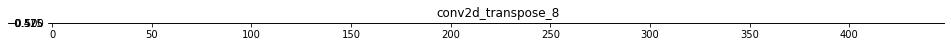

In [93]:
micae_in = [x.reshape(1,14,14,1) for x in micae_test_gen.split(enc_in.reshape(1,28,28), 14, 14)]
plot_activation(micae4x4, micae_in)

In [103]:
import tensorflow as tf

def deprocess_image(x):
    x -= x.mean() 
    x /= (x.std() + 1e-5) # standardize
    x *= 0.1 # scale
    
    x += 0.5  # center
    x = np.clip(x, 0, 1) # clip
    
    x *= 255
    x = np.clip(x, 0, 255).astype(np.uint8) # this clip is unnesecary.
    return x

def gen_pattern(model, layer_name, filter_index, size=28):
    input_image_data = np.random.random((1,size,size,1)) * 20 + 128  # init random (0..1) array and rescale+center
    input_image_data = tf.Variable(tf.cast(input_image_data, tf.float32)) # cast to tf var.
    
    epochs = 100
    step = 1.
    
    submodel = models.Model([model.inputs[0]], [model.get_layer(layer_name).output])
    
    for _ in range(epochs):
        with tf.GradientTape() as tape:
            outputs = submodel(input_image_data)
            loss = tf.reduce_mean(outputs[:, :, :, filter_index])
        grads = tape.gradient(loss, input_image_data)
        normalized_grads = grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
        input_image_data.assign_add(normalized_grads * step)
    return deprocess_image(input_image_data[0].numpy())

Visualizing the filters of the first and second conv layer for CAE:

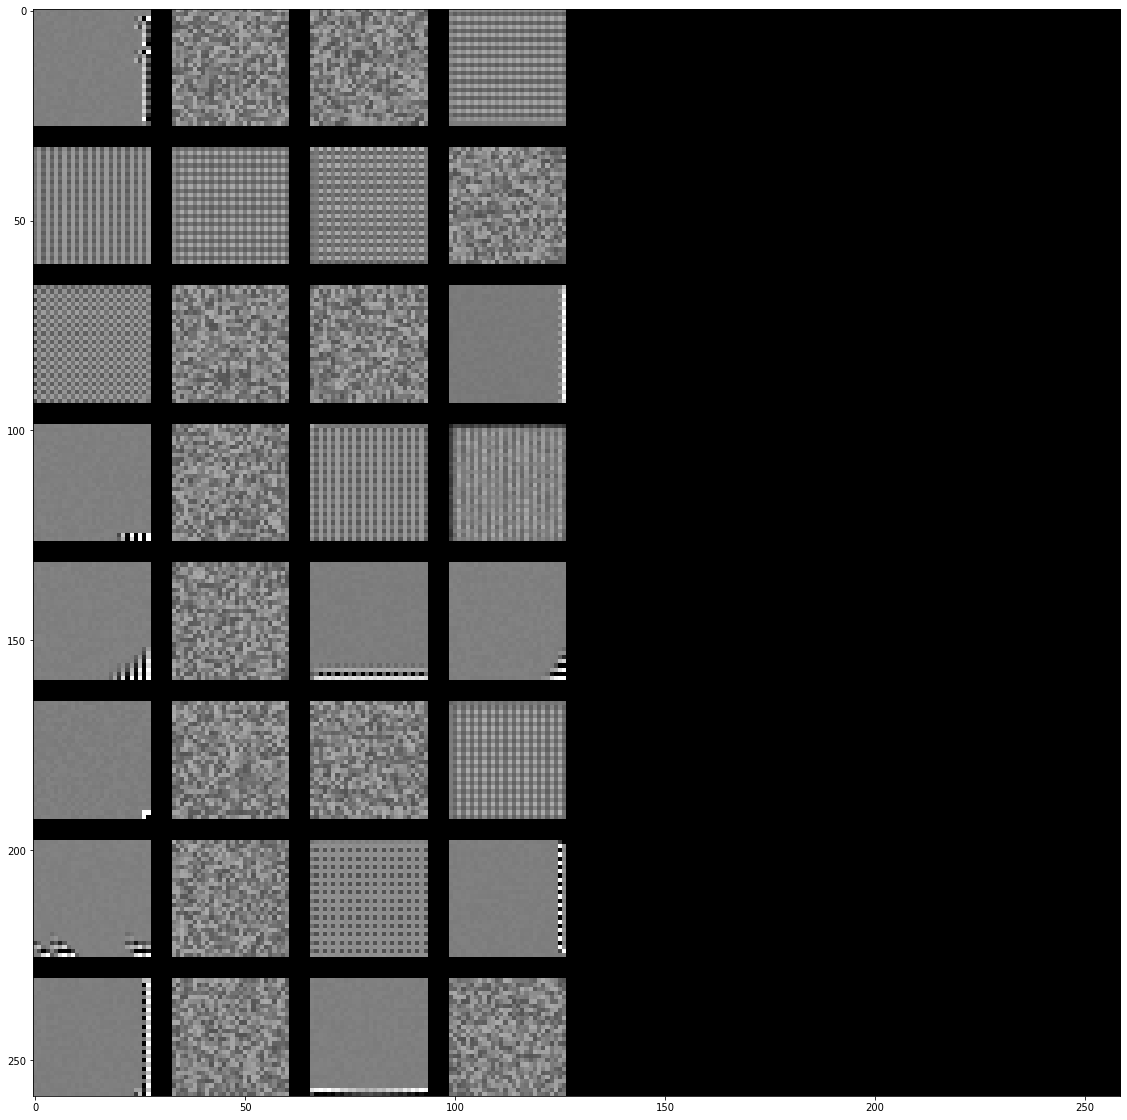

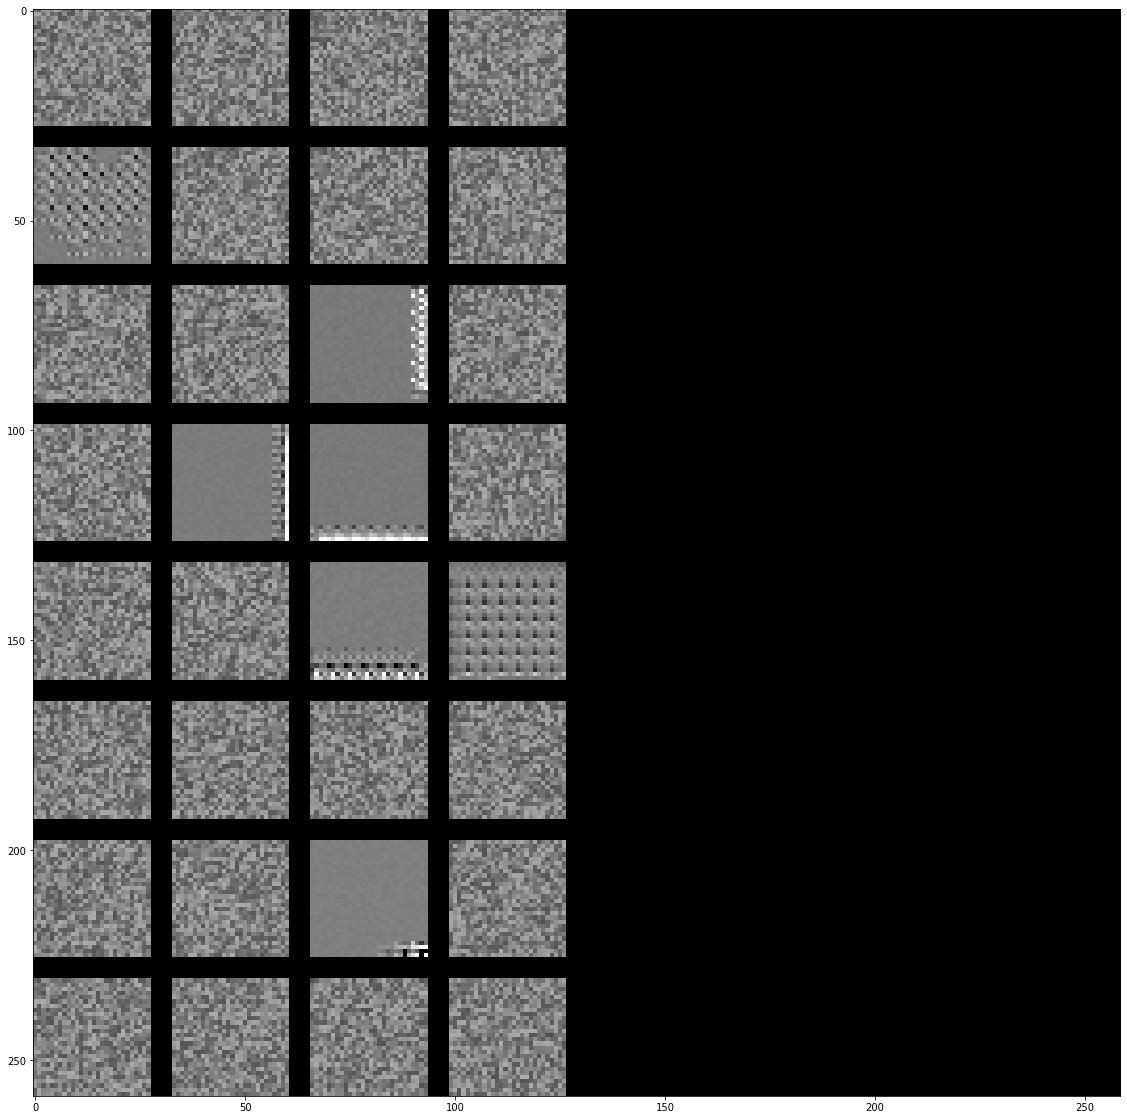

In [117]:
size = 28
margin = 5

for d in range(2,4):
    results = np.zeros((8*size+7*margin, 8*size+7*margin, 3))
    for i in range(8):
        for j in range(4):
            filter_img = gen_pattern(cae16.layers[2], 'conv2d_%d'%d, i+(j*8), size=size) # go through all the filters in the first layer (block1_conv1) of block1.
            horizontal_start = i*size + i*margin
            horizontal_end = horizontal_start + size
            vertical_start = j*size + j*margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end, vertical_start:vertical_end, :] = filter_img
    plt.figure(figsize=(20,20))
    plt.imshow(results.astype('uint8'))